# Generating Smooth Current and Atmospheric Patterns

***Shaunticlair Ruiz (based on document by Ian Fenty)***

This notebook is designed to help create semi-"realistic" conditions to run our advection-diffusion-forcing model under.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helper
import scipy

We borrow the following functionality from previous notebooks, saved in the helper.py file:

- ```helper.plot_multi_heatmap(many_states, nr, nc, titles, big_title, vmin=None, vmax=None)```

- ```helper.add_random_circles(matrix, num_circles, radius, values)```

- ```helper.make_M_2d_diffusion_advection_forcing(nr, nc, dt, KX, KY, DX_C, DY_C, DX_G, DY_G, VX, VY, RAC, F, cyclic_east_west = True, cyclic_north_south = False):```

- ```helper.compute_affine_time_evolution_simple(c0, M, r, num_saved_timesteps, duration_per_saved_timestep, debug = False)```

- ```helper.plot_2d_heatmap_time_evolution(saved_timesteps, state_over_time, nr, nc, vmin = None, vmax = None)```



Additionally, we've separately written up some code to plot arbitrary display 

-------
# Generating Covariance-Enforced Atmospheric Conditions
-------

### Objective

We want to generate a random 2D atmosphere, but we want it to behave in a way that seems realistic. In particular, we want nearby regions of the atmosphere to  behave similarly: in other words, nearby regions are *more strongly correlated*.

- This somewhat matches what we expect, physically: the weather at your house and across the street are usually pretty similar.

Rather than correlation, we'll encode this as the very related idea of **covariance**: whether, when the conditions of our two regions change, they tend to change together (they both go up/they both go down), or separately.

- We want nearby regions to have higher covariance: when the air temperature increases in one area, you expect it to increase in others nearby.

Mathematically, we can implement this behavior using a covariance matrix $\Sigma$, that we design to produce the desired behavior.

### Covariance Structure

What do we want from our covariance matrix? We want high covariance between regions which are *nearby*: it's a function of **distance**.

- This means that the **2D index** (the "position") of each data point determines how correlated it is with other data points.

- We decide which data points are closer by taking the **euclidean distance** between their indices:  
  - The indices of our two data points are $a=(i,j)$ and $b=(k,l)$. We'll represent distance as $\mathcal{D}$.

$$ \mathcal{D}(a,b) = ||a-b||^2 = (i-k)^2 + (j-l)^2$$

$\mathcal{D}$ computes how far our data points are. We want higher covariance if our data points are closer. So, we'll use a decaying exponential:

- A data point will have covariance 1 with itself.
- As $\mathcal{D}(a,b)$ increases, the covariance will decrease towards 0.
- We'll add a scaling factor $s$: the larger it is, the slower the correlation falls off with distance.

$$C_{a,b} = \sigma_{a,b}^2 = e^{-||a-b||^2/2s}$$

This is a simple **gaussian**.

In [2]:
def compute_covariance_gaussian_dropoff(a, b, std_dev = 1):
    """
    Compute Gaussian covariance matrix with exponential dropoff.

    Calculates covariance using e^{ -d / 2s }, where d is squared
    Euclidean distance between a and b, and s is the standard deviation std_dev.

    Args:
    a, b (array-like): Input vectors, represents spatial coordinates
    std_dev (float): Standard deviation of gaussian dropoff (default=1)

    Returns:
    numpy.ndarray: Covariance matrix
    """

    d = np.linalg.norm(a - b, axis=-1)**2      #Distance between a and b
    covariance = np.exp( -d / (2*std_dev))       #Covariance matrix

    return covariance

print(compute_covariance_gaussian_dropoff(np.array([0,0]), np.array([1,1])))

0.3678794411714422


### Flattening our 2D array

We have a slight problem:

- In order to compute covariance, we'll need the 2D indices.
- But a covariance matrix is structured to represent the covariances of a 1d array.

Our solution is to store each index in a 1d array, so we can reference it while building the covariancem matrix.

- If we want to know the index of element $m$ in the 1d array, we just have to read its value.

In [3]:
def vector_of_2d_indices(nr, nc):
    """
    Convert 2D array of indices to a 1D vector representation containing the same indices.

    Args:
    nr (int): Number of rows
    nc (int): Number of columns

    Returns:
    numpy.ndarray: Shape (nr*nc, 2), each row is [row, col] index
    """
    y, x = np.mgrid[:nr, :nc] #Get meshgrid of all of our indices
    vector_form = np.column_stack((y.ravel(), x.ravel())) #Stack
    return vector_form

print(vector_of_2d_indices(3,3))

[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]]


### Covariance Matrix

Now, we can compute the covariance between each pair of elements, and put it into a matrix.

- Note that, if our original matrix is $(n_r \times n_c)$, then it has $n_r n_c$ elements. 
- Thus, our covariance matrix must be $(n_r n_c \times n_rn_c)$.

In [4]:
nr, nc = 8,8

def compute_covariance_matrix_gaussian_dropoff(nr, nc, std_dev=1):
    """
    Compute covariance matrix with Gaussian dropoff for 2D grid.

    Compares all pairs of 2D indices and computes covariance using
    exponential dropoff function e^{ -d / 2s }, where 
    - d is squared Euclidean distance between a and b
    - s is the standard deviation std_dev.

    Args:
    nr, nc (int): Number of rows and columns in 2D grid
    std_dev (float): Standard deviation for Gaussian dropoff (default=1)

    Returns:
    np.ndarray: Covariance matrix of size (nr*nc, nr*nc)
    """
    # Get all 2D indices as a 1D vector of (row, col) pairs
    index_vector = vector_of_2d_indices(nr, nc)
    
    # Prepare indices for broadcasting
    indices_i = index_vector[:, np.newaxis, :]  # Shape: (nr*nc, 1, 2)
    indices_j = index_vector[np.newaxis, :, :]  # Shape: (1, nr*nc, 2)
    
    # Compute covariance matrix
    covariance_matrix = compute_covariance_gaussian_dropoff(
        indices_i,
        indices_j,
        std_dev=std_dev
    )
    
    return covariance_matrix

covariance_matrix = compute_covariance_matrix_gaussian_dropoff(nr, nc, std_dev=0.01)



### Plotting Covariance
We can plot this for an example data point, and see how the covariance falls off as we move away from our data point:

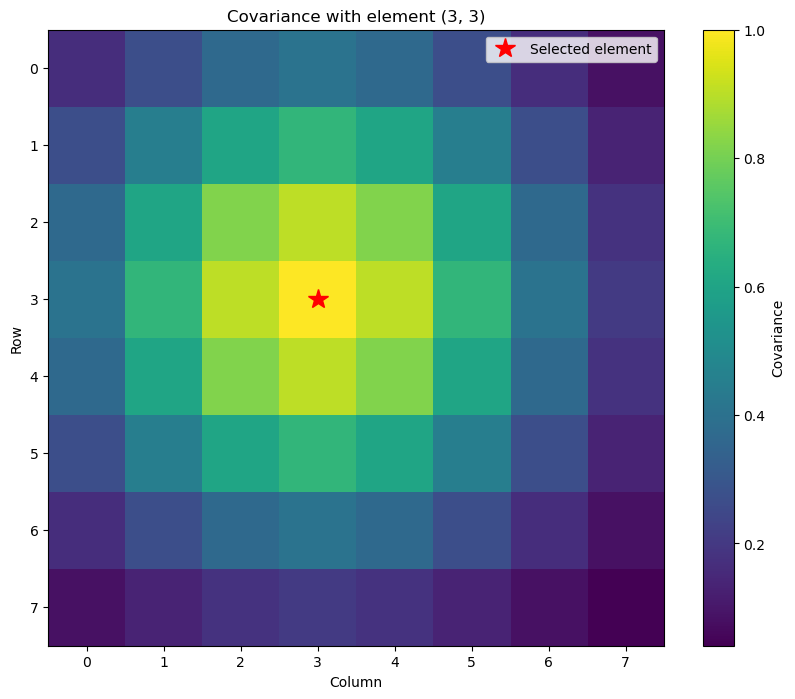

In [5]:
def plot_covariance_with_element(nr, nc, i, j, std_dev=1):
    """
    Plots the covariances of each element in the matrix with the selected element (i,j).

    This function computes a covariance matrix using Gaussian dropoff, then visualizes 
    the covariances of all elements with respect to a specified element (i,j).

    Visualization Notes:

    - The plot shows a heatmap of covariances.
    - The selected element is marked with a red star on the plot.

    Args:
    nr (int): Number of rows in the grid
    nc (int): Number of columns in the grid
    i (int): Row index of the selected element
    j (int): Column index of the selected element
    std_dev (float, optional): Standard deviation for Gaussian dropoff. Defaults to 1.

    Returns:
    None: Displays the plot using matplotlib
    
    """
    cov_matrix = compute_covariance_matrix_gaussian_dropoff(nr, nc, std_dev)

    # Only the covariance relative to (i,j)
    selected_index = i * nc + j 
    covariances = cov_matrix[selected_index]
    
    # Reshape into the original 2d array
    covariance_map = covariances.reshape(nr, nc)
    
    # Plot the covariance map
    plt.figure(figsize=(10, 8))
    plt.imshow(covariance_map, cmap='viridis')
    plt.colorbar(label='Covariance')
    plt.title(f'Covariance with element ({i}, {j})')
    plt.xlabel('Column')
    plt.ylabel('Row')
    
    # Mark the selected element
    plt.plot(j, i, 'r*', markersize=15, label='Selected element')
    plt.legend()
    
    plt.show()


#covariance_matrix = np.round(get_covariance_matrix(nr,nc),2)
plot_covariance_with_element(nr, nc, 3,3, std_dev=5)

### Cholesky Decomposition

Now, we want to create random data that, on average, follows the desired covariance above.

- We can accomplish this using the **Cholesky Decomposition** of our covariance matrix $Q$:

$$ Q = LL^\top$$

This is a sort of "square root" of covariance $Q$. Others can be used, such as LU decomposition, or SVD, but we'll choose this decomposition in particular.

### $Lz$ has covariance $Q$

How? Well, suppose that we create a random normal vector $z$, which has mean $\vec{0}$ and covariance $I$.

- We want to replace this with a vector having covariance $Q$.

We'll show that $Lz$ has the desired covariance $Q$.

$$V[Lz] = E[Lzz^\top L^\top] - E[Lz] E[Lz]^\top$$

We have $L$ as a known constant, so we can pull it out:

$$V[Lz] = L E[zz^\top ] L^\top - L E[z] E[Lz]^\top$$

Two useful facts:

- $E[z]=0$, so we can erase the second term entirely.
- You can use $E[z] = \vec{0}$ and $V[z] = I$ to show that $E[zz^\top]=I$. So, it vanishes from the multiplication.

$$V[Lz] = LL^\top = Q$$

$Lz$ has the desired covariance.

### Testing our results

We can run a bunch of examples to show that we find the intended covariance.

In [6]:
L = np.linalg.cholesky(covariance_matrix)

# We'll generate many samples of f, and use that to approximate the covariance matrix
n = 10000
Lz = []
for i in range(n):
    z_i = np.random.normal(0,1,nr*nc) # generate random noise
    Lz_i = L @ z_i
    Lz.append(Lz_i)

#Compute covariance of Lz
Lz = np.array(Lz).T
C = Lz @ Lz.T / n


C = np.round(C / np.max(C),2)
#print(C)
Ctrue = np.round(covariance_matrix / np.max(C),2)
#print(Ctrue)
print(C - Ctrue)

## As n increases, the covariance matrix converges to the true covariance matrix

[[-0.03  0.01 -0.02 ... -0.01  0.02 -0.  ]
 [ 0.01  0.    0.   ... -0.    0.01  0.01]
 [-0.02  0.   -0.03 ... -0.   -0.02  0.02]
 ...
 [-0.01 -0.   -0.   ... -0.04  0.    0.01]
 [ 0.02  0.01 -0.02 ...  0.   -0.04 -0.01]
 [-0.    0.01  0.02 ...  0.01 -0.01 -0.03]]


Based on this, we can create some simple functions:

In [7]:
def generate_random_vector_mean_0_cov_C(nr, nc, C):
    """
    Generates a random vector from a normal distribution with mean 0 and covariance C.

    Args:
    nr, nc (int): Dimensions of the 2D grid
    C (np.ndarray): Covariance matrix

    Returns:
    tuple: (z, Lz)
        z (np.ndarray): Random normal vector with mean 0 and covariance I    
            z ~ N(0, I)
        Lz (np.ndarray): Random vector with mean 0 and covariance C
            Lz ~ N(0, C)
    """
    z = np.random.randn(nr*nc,1)
    L = np.linalg.cholesky(C)
    Lz = L @ z
    return z, Lz

def generate_random_vectors_mean_0_cov_C(nr, nc, C, num_vectors):
    """
    Generates random vectors from a normal distribution with mean 0 and covariance C.

    Args:
    nr, nc (int): Dimensions of the 2D grid
    C (np.ndarray): Covariance matrix
    num_vectors (int): Number of random vectors to generate

    Returns:
    tuple: (zs, Lzs)
        zs (list): Random normal vectors with mean 0 and covariance I    
            z ~ N(0, I)
        Lzs (list): Random vectors with mean 0 and covariance C
            Lz ~ N(0, C)
    """
    size = nr * nc #Size of the grid
    zs = [np.random.randn(size, 1) for _ in range(num_vectors)] #Random normal vectors with mean 0 and covariance I

    # If z ~ N(0, I), then Lz ~ N(0, C)
    L = np.linalg.cholesky(C) 
    Lzs = [L @ z for z in zs] #Random vectors with mean 0 and covariance C

    return zs, Lzs

And we visualize the result.

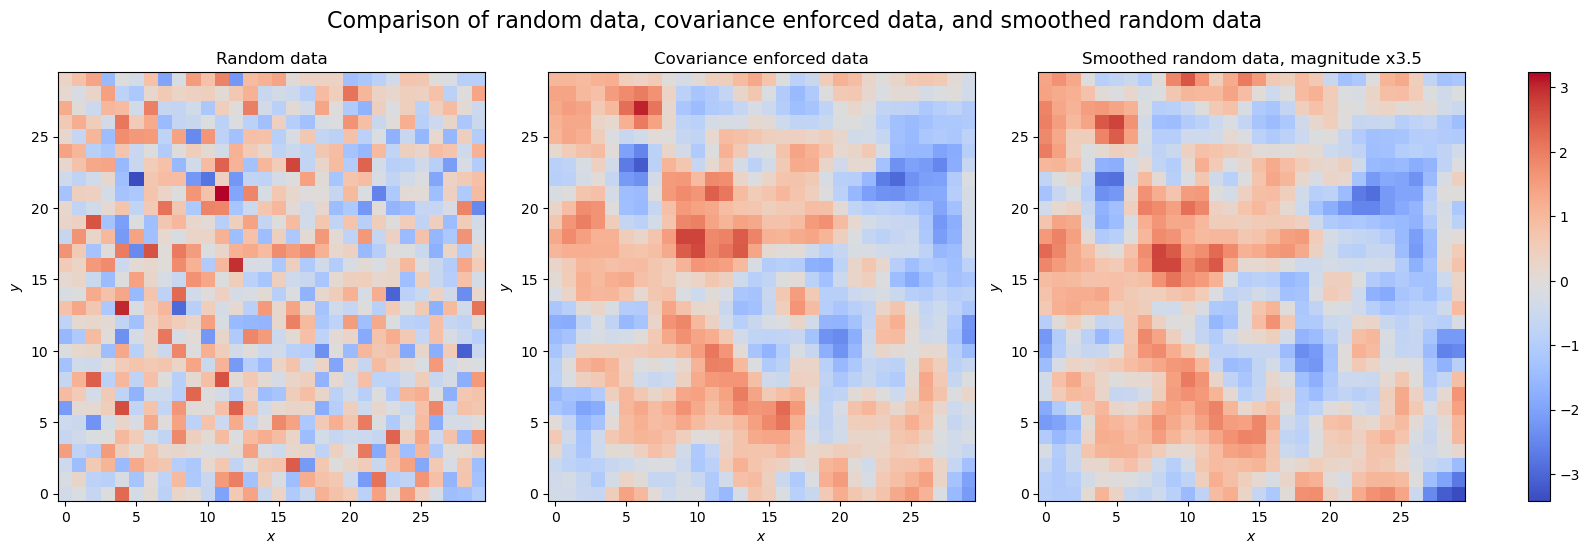

In [8]:
nr,nc=30,30
covariance_matrix = compute_covariance_matrix_gaussian_dropoff(nr, nc, std_dev=2)

#Create a third version where we smooth out our data using a simple filter
def smooth_data(data, nr, nc):
    """
    Smooths 2D data using a Gaussian filter.

    Args:
    data (np.ndarray): 1D representation of 2d data to be smoothed
    nr (int): Number of rows in the 2D representation of the data
    nc (int): Number of columns in the 2D representation of the data

    Returns:
    np.ndarray: 1D array of smoothed data

    """
    data = data.reshape(nr, nc)
    smoothed_data = scipy.ndimage.gaussian_filter(data, sigma=1)
    return smoothed_data.ravel()


random_data, covariance_enforced_data = generate_random_vector_mean_0_cov_C(nr, nc, covariance_matrix)

# Plot the comparison between all three
helper.plot_multi_heatmap(
    many_states=[random_data, covariance_enforced_data, 3.5*smooth_data(random_data, nr, nc)],
    nr=nr,
    nc=nc,
    titles=['Random data', 'Covariance enforced data', 'Smoothed random data, magnitude x3.5'],
    big_title='Comparison of random data, covariance enforced data, and smoothed random data'
)
                                

### Comments

When you imagine taking random data and transforming it into data that's spatially covariant, you might expect it to be a "smoothed out" version of the original data.

- You take each cell and average it with its neighbors: this increases the covariance between them, right?

It turns out that, as we see above, this is *similar* to what our observation does, but not identical: it seems that the magnitude gets scaled down by smoothing, but not when we use the covariance transformation.

-------
# Generating Circulating Current Flows
-------

Next, we want to create a more realistic current pattern. For example, we don't want a flow that pushes all of our water into one place: that doesn't make sense!

- This kind of flow, where we don't want water to build up in/drain out of a region is called **non-divergent flow**.

Our solution will be to create "loops" of current: water doesn't collect anywhere, but rather cycles through the same path, repeatedly.

But how do we decide where to put our loops?

- One way to create a loop, is to walk around a hill, staying at the same height (following the "isocline"), until you come back to the same place.
- Based on this, we just need to 1. create hills and 2. create isoclines around those hills.

Our "hills" will be gaussian distributions, and we'll move around the hills by going **perpendicular** to the uphill/downhill direction.

- This means we'll move perpendicular to the *gradient*.

(31, 31)
(31, 31)


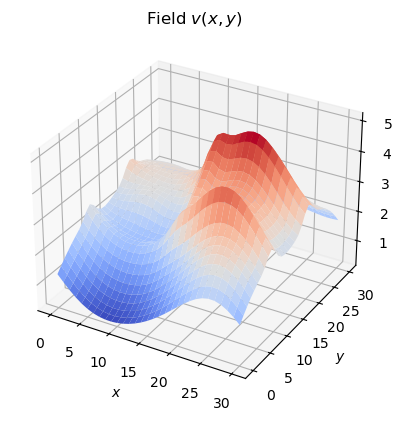

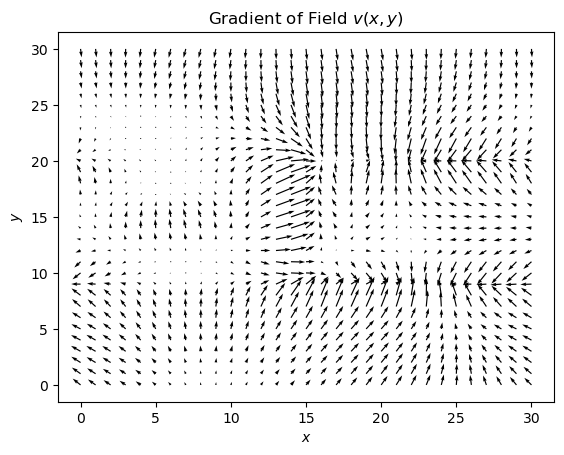

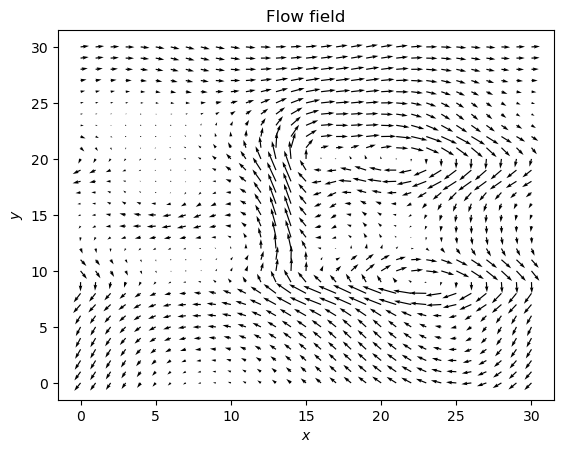

In [9]:
#Randomly generate n gaussian functions in 2d, with distinct means and sds
n = 16
nrv,ncv=nr+1,nc+1 #We need one more point so we can put each arrow on the boundary of a cell

def generate_gaussian_field(n, nrv, ncv):
    """
    Randomly generates a 2D field composed of n Gaussian functions with distinct means and standard deviations.

    Args:
    n (int): Number of Gaussian functions to generate
    nrv (int): Number of rows in the field
    ncv (int): Number of columns in the field

    Returns:
    np.ndarray: A 2D array representing the generated Gaussian field

    Notes:
    - The field is made pseudo-periodic by creating three copies of each Gaussian function
    """
    mux = np.random.choice(ncv, n)
    muy = np.random.choice(range(2, nrv - 2), n)
    sigmax = np.random.uniform(1,ncv/4,n)
    sigmay = np.random.uniform(1,nrv/4,n)

    #Combine all the gaussian functions to get the field

    v = np.zeros((nrv,ncv))
    for i in range(n):
        for x in range(ncv):
            for y in range(nrv):
                #We create three copies of our gaussian so that we get a pseudo-periodic field

                # Original Gaussian
                gauss  = np.exp(-((x-mux[i])**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                # Shifted left
                gauss += np.exp(-((x-(mux[i]-ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                # Shifted right
                gauss += np.exp(-((x-(mux[i]+ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))

                v[y,x] += gauss 

    return v

def generate_circular_field(v):
    """
    Generates a circular field by taking the gradient of the input field and rotating it by 90 degrees.

    Args:
    v (np.ndarray): Input 2D field

    Returns:
    tuple: (grad_v_x, grad_v_y)
        grad_v_x (np.ndarray): X-component of the circular field
        grad_v_y (np.ndarray): Y-component of the circular field
    """
    grad_v_y, grad_v_x = np.gradient(v)

    return -grad_v_y, grad_v_x

v = generate_gaussian_field(n, nrv, ncv)


# Plot the field in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
rows = np.arange(nrv)
cols = np.arange(ncv)
X, Y = np.meshgrid(cols, rows)
print(v.shape)
print(X.shape)
ax.plot_surface(X,Y, v, cmap='coolwarm')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$v$')
plt.title('Field $v(x,y)$')
plt.show()


# Compute the gradient at every point in the field
grad_v_y, grad_v_x = np.gradient(v)
# View the gradient
plt.figure()
plt.quiver(X, Y, grad_v_x, grad_v_y)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Gradient of Field $v(x,y)$')
plt.show()

circle_x, circle_y = generate_circular_field(v)
# Plot the perpendicularly rotated gradient
plt.figure()
plt.quiver(X, Y, circle_x, circle_y)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Flow field')
plt.show()

-------
# Simulating our Smoothened Conditions
-------

Now that we have a configuration set up, we can run a simulation on it.

- Atmospheric forcing given by smooth, covariance-enforced noise
- Currents given by gradient perpendiculars in circular, non-divergent flows

In [10]:
def create_random_initial_ocean_state(nr, nc, C, num_circles, radius, values):
    """
    Creates a random initial ocean state with specified covariance matrix.

    Args:
    nr (int): Number of rows in the grid
    nc (int): Number of columns in the grid
    C (np.ndarray): Covariance matrix for the initial state
    num_circles (int): Number of random circles to add
    radius (int): Radius of circles
    values (list): Possible values for circles

    Returns:
    tuple: (z, Lz)
        z (np.ndarray): Random initial state with covariance C
        Lz (np.ndarray): Random initial state with covariance
    """

    z = np.random.rand(nr,nc)
    z = helper.add_random_circles(z, num_circles, radius, values)
    z = z.reshape((nr*nc,1))

    L = np.linalg.cholesky(C)
    Lz = L @ z

    return z, Lz

In [11]:
c0 = create_random_initial_ocean_state(nr, nc, covariance_matrix, num_circles=20, radius=5, values=[2,-2])[1]

In [12]:
def create_random_model(nr, nc, dt, F, 
                        num_gauss = 16,
                        DX_C = None, DY_C = None, DX_G = None, DY_G = None, RAC = None,
                        cyclic_east_west=True, cyclic_north_south=False):
    """
    Creates a random model with a new velocity field and diffusivity field.

    - Velocity field is generated from a field of circular patterns, in order to create a field
    with low divergence.

    - Diffusivity field is generated randomly, with 0 diffusivity on the boundaries.

    Args:
    nr (int): Number of rows in the grid
    nc (int): Number of columns in the grid
    dt (float): Time step
    F (float): Forcing parameter
    num_gauss (int, optional): Number of Gaussian functions for velocity field generation. Defaults to 16.
    DX_C, DY_C, DX_G, DY_G, RAC (np.ndarray, optional): Grid spacing and area parameters. If None, set to arrays of ones.
    cyclic_east_west (bool, optional): If True, applies cyclic conditions east-west. Defaults to True.
    cyclic_north_south (bool, optional): If True, applies cyclic conditions north-south. Defaults to False.

    Returns:
    tuple: (M, params)
        M (np.ndarray): Model matrix for 2D diffusion-advection-forcing
        params (dict): Dictionary of parameters used to create the model

    """
    # If none, just set everything to appropriately-sized array of 1's
    if DX_C is None:
        DX_C = np.ones((nr, nc+1))
    if DY_C is None:
        DY_C = np.ones((nr+1, nc))
    if DX_G is None:
        DX_G = np.ones((nr+1, nc))
    if DY_G is None:
        DY_G = np.ones((nr, nc+1))
    if RAC is None:
        RAC = np.ones((nr, nc))
    


    # Randomly generate diffusivities: must be positive
    KX = np.random.rand(nr, nc+1)
    KY = np.random.rand(nr+1, nc)
    KX = np.abs(KX)
    KY = np.abs(KY)

    # Randomly generate velocities as above
    gauss = generate_gaussian_field(num_gauss,nr+1,nc+1)
    VX, VY = generate_circular_field(gauss)

    # Create the model matrix
    params = {
        'nr': nr,
        'nc': nc,
        'dt': dt,
        'KX': KX,
        'KY': KY,
        'DX_C': DX_C,
        'DY_C': DY_C,
        'DX_G': DX_G,
        'DY_G': DY_G,
        'VX': 100*VX[:-1,:],
        'VY': 100*VY[:,:-1],
        'RAC': RAC,
        'F': F,
        'cyclic_east_west':  cyclic_east_west,
        'cyclic_north_south': cyclic_north_south
    }

    M = helper.make_M_2d_diffusion_advection_forcing(**params)

    return M, params

In [13]:
dt = 0.001
F  = 0.05

M, params = create_random_model(nr, nc, dt, F)

#Unpack params
nr, nc, dt, KX, KY, DX_C, DY_C, DX_G, DY_G, VX, VY, RAC, F, cyclic_east_west, cyclic_north_south = params.values()

#Use func to get initial ocean state
_, c0 = create_random_initial_ocean_state(nr, nc, covariance_matrix, num_circles=20, radius=5, values=[2,-2])

#Use func to get atmosphere
_, f = generate_random_vector_mean_0_cov_C(nr, nc, covariance_matrix)

X shape: (30, 30), Y shape: (30, 30), VX shape: (30, 31), VY shape: (31, 30)
After adjustment - X shape: (30, 30), Y shape: (30, 30), VX_plot shape: (30, 30), VY_plot shape: (30, 30)


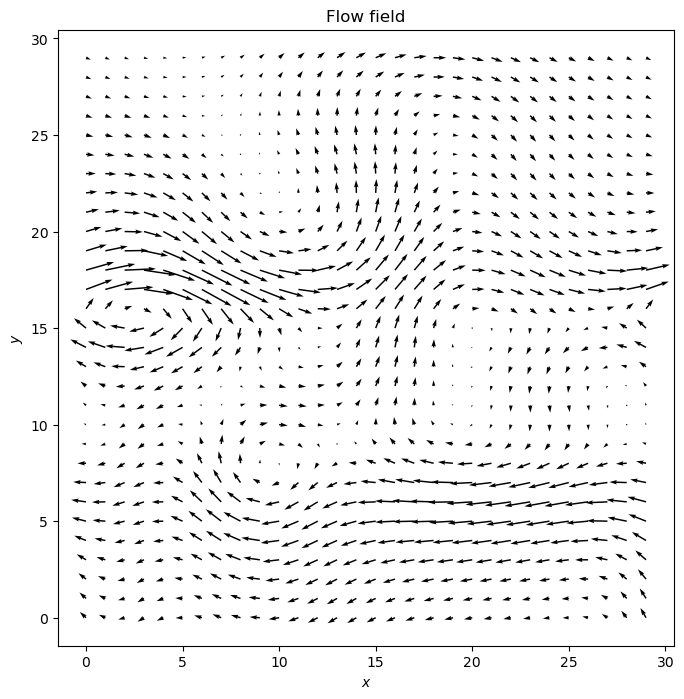

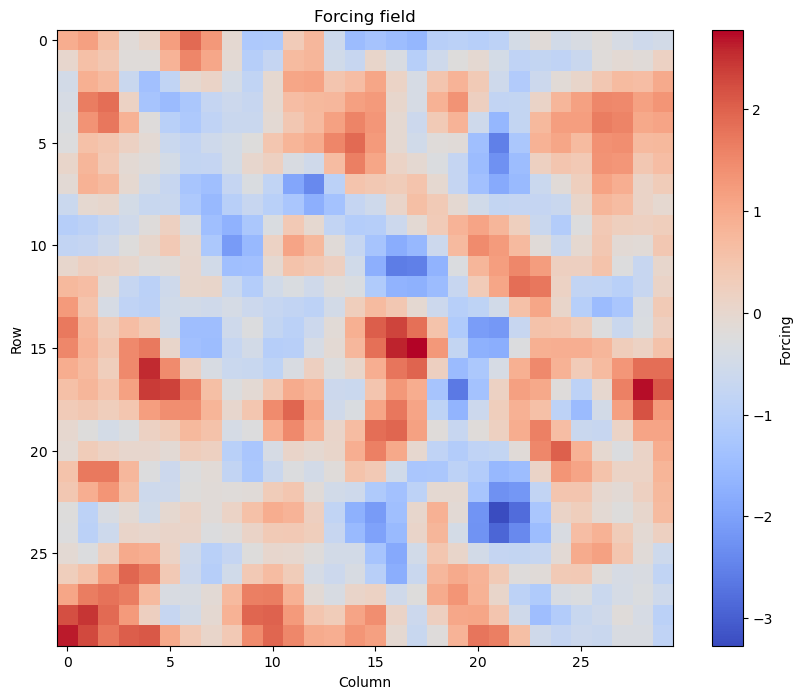

c0 shape: (900, 1), M shape: (900, 900), f shape: (900, 1)


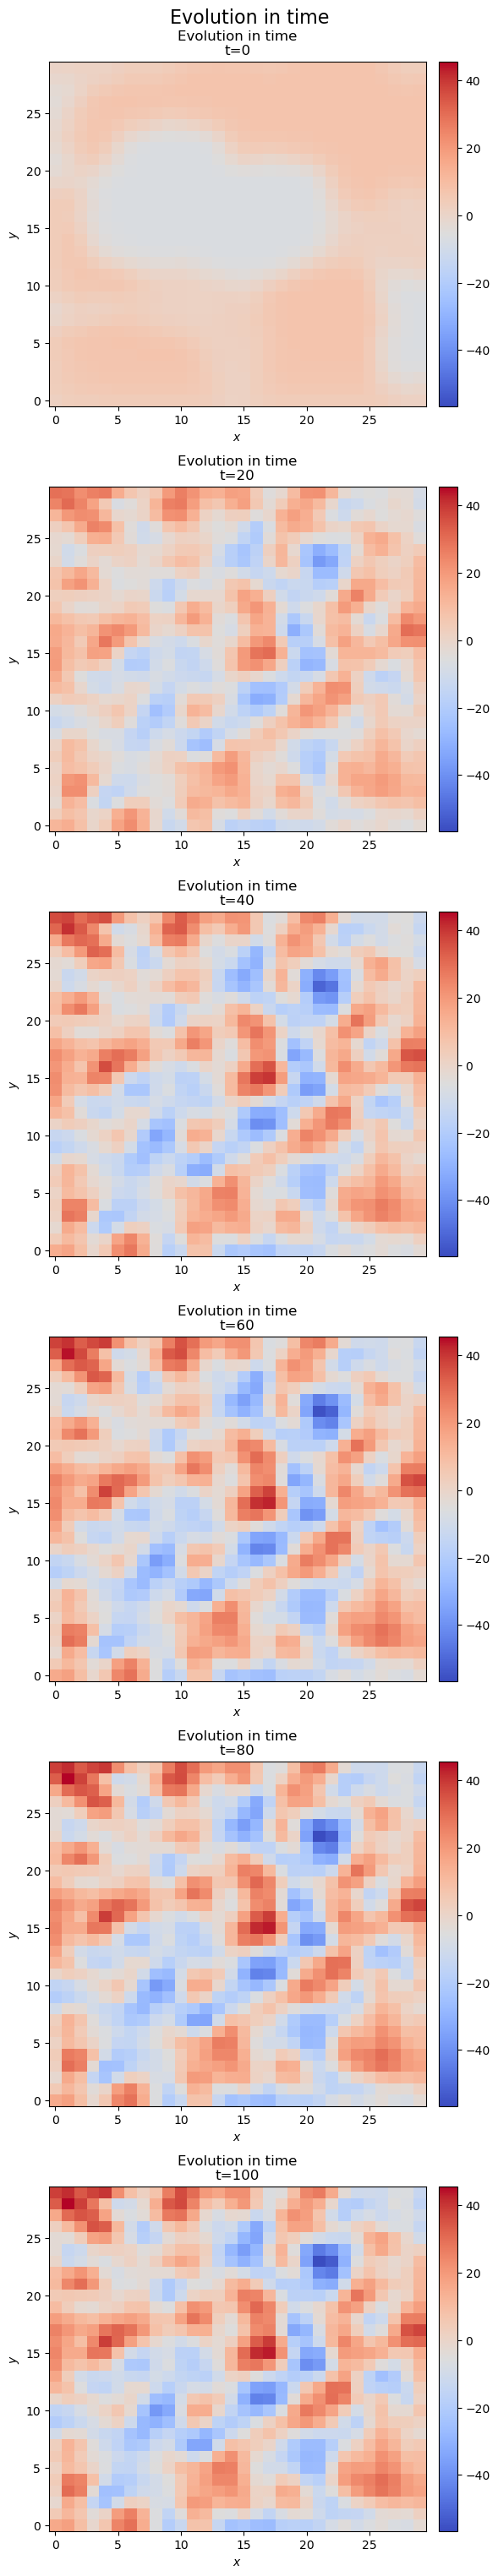

In [14]:
# Plot the field in 3d
nrv, ncv = nr+1, nc+1
rows = np.arange(nr)
cols = np.arange(nc)
X, Y = np.meshgrid(cols, rows)

print(f"X shape: {X.shape}, Y shape: {Y.shape}, VX shape: {VX.shape}, VY shape: {VY.shape}")

# Adjust VX and VY to match X and Y dimensions
VX_plot = VX[:nr, :nc]
VY_plot = VY[:nr, :nc]

print(f"After adjustment - X shape: {X.shape}, Y shape: {Y.shape}, VX_plot shape: {VX_plot.shape}, VY_plot shape: {VY_plot.shape}")

# Plot the perpendicularly rotated gradient
plt.figure(figsize=(10, 8))
plt.quiver(X, Y, VX_plot, VY_plot)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Flow field')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Plot the forcing field
plt.figure(figsize=(10, 8))
plt.imshow(f.reshape(nr, nc), cmap='coolwarm')
plt.colorbar(label='Forcing')
plt.title('Forcing field')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

num_saved_timesteps = 6
duration_per_saved_timestep = 20

print(f"c0 shape: {c0.shape}, M shape: {M.shape}, f shape: {f.shape}")

saved_timesteps, state_over_time = helper.compute_affine_time_evolution_simple(c0, M, f, num_saved_timesteps, duration_per_saved_timestep)
helper.plot_2d_heatmap_time_evolution(saved_timesteps, state_over_time, nr, nc)

# World Generation for Convenience

Often, we'll want to do all of these things at once. So, we'll create a function that runs through each of these.

In [15]:
def generate_world(nr, nc, dt, F, num_gauss=16, num_circles=20, radius=5, values=[2,-2], std_dev=2):
    """
    Generates a world with an ocean state, atmosphere, and model matrix.

    Args:
    nr (int): Number of rows in the grid
    nc (int): Number of columns in the grid
    dt (float): Time step
    F (float): Forcing parameter
    num_gauss (int, optional): Number of Gaussian functions for velocity field generation. Defaults to 16.
    num_circles (int, optional): Number of circles for ocean state generation. Defaults to 20.
    radius (int, optional): Radius of circles for ocean state generation. Defaults to 5.
    values (list, optional): Values of circles for ocean state generation. Defaults to [2,-2].
    std_dev (int, optional): Standard deviation for Gaussian dropoff. Defaults to 2.

    Returns:
    tuple: (C, c0, f, M)
        C (np.ndarray): Covariance matrix
        c0 (np.ndarray): Initial ocean state
        f (np.ndarray): Atmosphere
        M (np.ndarray): Model matrix
    """
    # Generate covariance matrix
    C = compute_covariance_matrix_gaussian_dropoff(nr, nc, std_dev)

    # Generate model matrix
    M, params = create_random_model(nr, nc, dt, F, num_gauss=num_gauss)

    # Generate initial ocean state
    _, c0 = create_random_initial_ocean_state(nr, nc, C, num_circles=num_circles, radius=radius, values=values)

    # Generate atmosphere
    _, f = generate_random_vector_mean_0_cov_C(nr, nc, C)

    return C, c0, f, M